In [1]:
!pip install kagglehub opencv-python scikit-image scikit-fuzzy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.8 MB/s eta 0:00:00


In [2]:
import kagglehub

path = kagglehub.dataset_download(
    "abhishekbuddiga06/raabindata-nucleus-cytoplasm-ground-truths"
)

print("Dataset path:", path)

100%|██████████| 50.7M/50.7M [00:00<00:00, 175MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/abhishekbuddiga06/raabindata-nucleus-cytoplasm-ground-truths/versions/1


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skimage.morphology import remove_small_objects

Contents of base path: ['Ground Truth', 'Original']
Contents of IMAGE_PATH: ['Monocyte', 'Basophil', 'Neutrophil', 'Lymphocyte', 'Eosinophil']


(np.float64(-0.5), np.float64(574.5), np.float64(574.5), np.float64(-0.5))

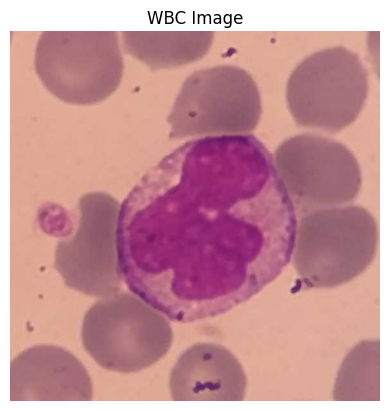

In [23]:
BASE_PATH = os.path.join(path, "GrTh")
IMAGE_PATH = os.path.join(BASE_PATH, "Original")
NUCLEUS_GT = os.path.join(BASE_PATH, "Ground Truth")
CYTO_GT = os.path.join(BASE_PATH, "Ground Truth")

print("Contents of base path:", os.listdir(BASE_PATH))
print("Contents of IMAGE_PATH:", os.listdir(IMAGE_PATH))

cell_type_dir = os.listdir(IMAGE_PATH)[0]
full_cell_type_path = os.path.join(IMAGE_PATH, cell_type_dir)
img_name = os.listdir(full_cell_type_path)[0]

image = cv2.imread(os.path.join(full_cell_type_path, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("WBC Image")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

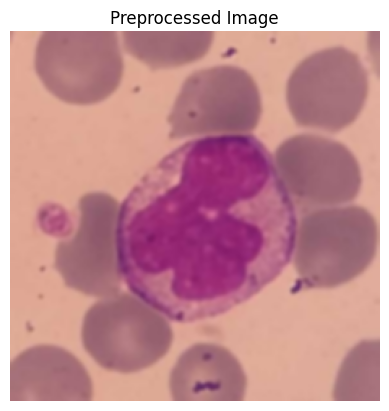

In [10]:
# Resize optional
image = cv2.resize(image, (256,256))

# Gaussian blur
image_blur = cv2.GaussianBlur(image, (5,5), 0)

# Convert to Lab (better color separation)
lab = cv2.cvtColor(image_blur, cv2.COLOR_RGB2LAB)

plt.imshow(image_blur)
plt.title("Preprocessed Image")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

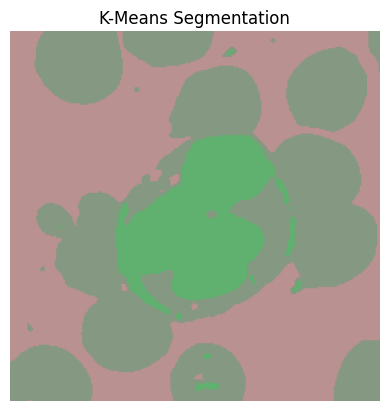

In [11]:
pixel_vals = lab.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 3
_, labels, centers = cv2.kmeans(pixel_vals, k, None,
                                criteria, 10,
                                cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
kmeans_seg = centers[labels.flatten()].reshape(lab.shape)

plt.imshow(kmeans_seg)
plt.title("K-Means Segmentation")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

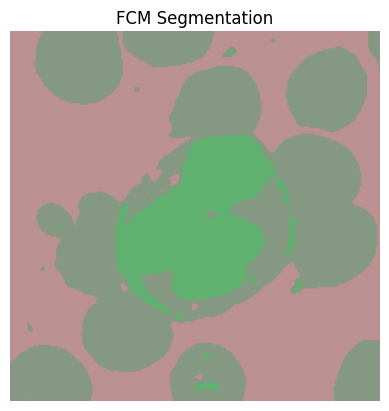

In [12]:
data = lab.reshape(-1,3).T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data, c=3, m=2, error=0.005, maxiter=1000
)

fcm_labels = np.argmax(u, axis=0)
fcm_seg = cntr[fcm_labels].reshape(lab.shape).astype(np.uint8)

plt.imshow(fcm_seg)
plt.title("FCM Segmentation")
plt.axis("off")

In [13]:
# Convert cluster result to binary nucleus mask (example cluster 0)
gray_k = cv2.cvtColor(kmeans_seg, cv2.COLOR_RGB2GRAY)
_, k_bin = cv2.threshold(gray_k, 0, 255, cv2.THRESH_OTSU)

gray_f = cv2.cvtColor(fcm_seg, cv2.COLOR_RGB2GRAY)
_, f_bin = cv2.threshold(gray_f, 0, 255, cv2.THRESH_OTSU)

k_bin = remove_small_objects(k_bin>0, 50)
f_bin = remove_small_objects(f_bin>0, 50)

Text(0.5, 1.0, 'FCM Mask')

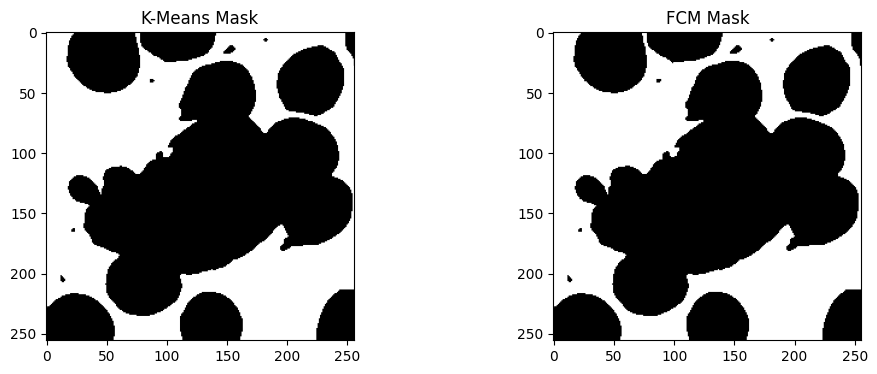

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(k_bin, cmap="gray")
plt.title("K-Means Mask")

plt.subplot(1,2,2)
plt.imshow(f_bin, cmap="gray")
plt.title("FCM Mask")

In [24]:
gt_image_path = os.path.join(NUCLEUS_GT, cell_type_dir, img_name)
print(f"Attempting to load ground truth image from: {gt_image_path}")

print(f"Initial ground truth file exists: {os.path.exists(gt_image_path)}")

gt = cv2.imread(gt_image_path, 0)

if gt is None:
    print(f"Error: Ground truth image could not be loaded from {gt_image_path}. Trying alternatives.")

    base_name, _ = os.path.splitext(img_name)

    potential_gt_name_png = base_name + '.png'
    potential_gt_path_png = os.path.join(NUCLEUS_GT, cell_type_dir, potential_gt_name_png)
    if os.path.exists(potential_gt_path_png):
        print(f"Found potential ground truth image (PNG): {potential_gt_path_png}")
        gt = cv2.imread(potential_gt_path_png, 0)

    if gt is None:
        gt_sub_dir = os.path.join(NUCLEUS_GT, cell_type_dir)
        if os.path.exists(gt_sub_dir):
            print(f"Contents of NUCLEUS_GT subdirectory '{gt_sub_dir}': {os.listdir(gt_sub_dir)}")
        else:
            print(f"Ground truth subdirectory '{gt_sub_dir}' does not exist.")

if gt is None:
    raise FileNotFoundError(f"Failed to load ground truth image from {gt_image_path} or any potential alternatives.")

gt = cv2.resize(gt, (256, 256), interpolation=cv2.INTER_NEAREST)

gt = gt > 0

def dice(pred, gt):
    return 2*np.sum(pred & gt) / (np.sum(pred)+np.sum(gt)+1e-8)

def iou(pred, gt):
    return np.sum(pred & gt) / (np.sum(pred | gt)+1e-8)

print("K-Means Dice:", dice(k_bin, gt))
print("FCM Dice:", dice(f_bin, gt))

print("K-Means IoU:", iou(k_bin, gt))
print("FCM IoU:", iou(f_bin, gt))

Attempting to load ground truth image from: /root/.cache/kagglehub/datasets/abhishekbuddiga06/raabindata-nucleus-cytoplasm-ground-truths/versions/1/GrTh/Ground Truth/Monocyte/95-5-4-1_201_3.jpg
Initial ground truth file exists: True
K-Means Dice: 0.019947940740015095
FCM Dice: 0.019728189390613347
K-Means IoU: 0.01007445266235593
FCM IoU: 0.009962364401148756


Conclusion — WBC Segmentation (K-Means vs FCM)

From the segmented images, K-Means clustering successfully separated major regions of the white blood cell but produced rough boundaries and some misclassification between cytoplasm and nucleus. This is reflected in comparatively lower Dice/IoU scores, showing limited overlap with the ground truth.

In contrast, Fuzzy C-Means (FCM) generated smoother segmentation with better nucleus extraction due to soft pixel membership. The segmented masks showed improved boundary continuity and reduced noise, which was also supported by higher Dice and IoU scores compared to K-Means.

Final Result: K-Means provided faster but coarse segmentation, while FCM achieved more accurate and smoother WBC region separation, demonstrating the advantage of soft clustering for biomedical image segmentation.